<a href="https://colab.research.google.com/github/gyulab/gtee-bti-mlproject/blob/data-gen/IWO_reliability_data_gen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PBTI Data Training
Param: vgs, vds, Lg, temp, Ts


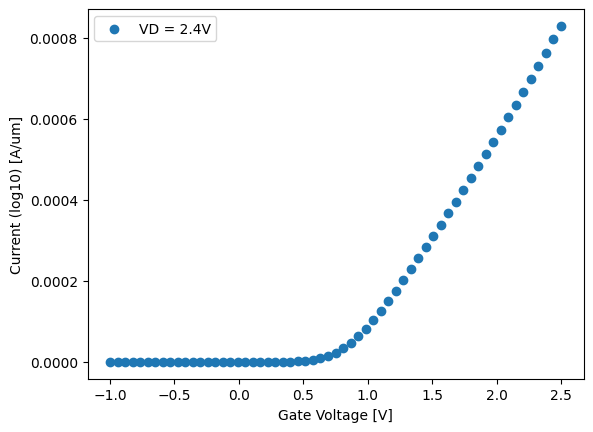

In [2]:
from re import L
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

from torch import optim
from torch.utils import data
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt


import statistics
import datetime
import os
import csv
import math
import time
import numpy as np
import os

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

os.getcwd()

start = time.time()


idvg_temp = pd.read_csv(r'/content/drive/MyDrive/Colab_ML_ProfYu/csv_data/042324_DG_IWO_Lg50nm_IV.csv', encoding='utf8')
cv_temp = pd.read_csv(r'/content/drive/MyDrive/Colab_ML_ProfYu/csv_data/cv_iwo_0212_dataset.csv', encoding='utf8')

y_values = idvg_temp.iloc[:, 3]

# Generate random variations for y-axis values
# np.random.uniform(low, high, size) generates random numbers between low and high
y_variation = np.random.uniform(-0.1, 0.1, size=y_values.shape) * y_values

# Apply the variations to y-axis values
y_values_varied = y_values + y_variation



# If you want to replace the original column with the modified data
#idvg_temp.iloc[:, 51] = modified_data

# Now idvg_temp.iloc[:, 51] contains the data after applying ±10% random variation

Vg_test = list(idvg_temp.iloc[:, 0])

# Assuming x-axis values are a sequence or can be represented similarly
# If you have specific x-axis values, replace np.arange(len(y_values)) with your x-axis data
x_values = np.array(Vg_test)

# Generate random variations for x-axis values
x_variation = np.random.uniform(-0.1, 0.1, size=x_values.shape) * x_values

# Apply the variations to x-axis values
x_values_varied = x_values + x_variation


Id0_test = list(idvg_temp.iloc[:, 3])
Id_test = list(y_values_varied)
Id2_test = list(idvg_temp.iloc[:, 51])

xv_test = np.array(range(-10, 36, 1))/10
vd_temp=[0.01, 0.012, 0.015, 0.018, 0.022, 0.027, 0.034, 0.041, 0.050, 0.062, 0.075, 0.092, 0.113, 0.138, 0.169, 0.207, 0.253, 0.310, 0.379, 0.464, 0.568, 0.695, 0.851, 1.042, 1.275, 1.560, 1.9600, 2.337, 2.86, 3.4]


#plt.scatter(Vg_test, Id0_test, label = "VD = Original") ## TCAD
#plt.scatter(x_values_varied, Id_test, label = "VD = 10% variation") ## TCAD
plt.scatter(Vg_test, Id2_test, label = "VD = 2.4V") ## TCAD
#plt.plot(vd_temp, np.log10(Id0_test), label = "VD = 0.05V")
#plt.plot(vd_temp, np.log10(Id_test), label = "VD = 1V")
#plt.plot(vd_temp, np.log10(Id2_test), label = "VD = 2.4V")
plt.xlabel("Gate Voltage [V]")
plt.ylabel("Current (log10) [A/um]")
plt.legend()
plt.show()

Data Modeling

[-1.         -0.94166667 -0.88333333 -0.825      -0.76666667 -0.70833333
 -0.65       -0.59166667 -0.53333333 -0.475      -0.41666667 -0.35833333
 -0.3        -0.24166667 -0.18333333 -0.125      -0.06666667 -0.00833333
  0.05        0.10833333  0.16666667  0.225       0.28333333  0.34166667
  0.4         0.45833333  0.51666667  0.575       0.63333333  0.69166667
  0.75        0.80833333  0.86666667  0.925       0.98333333  1.0416667
  1.1         1.1583333   1.2166667   1.275       1.3333333   1.3916667
  1.45        1.5083333   1.5666667   1.625       1.6833333   1.7416667
  1.8         1.8583333   1.9166667   1.975       2.0333333   2.0916667
  2.15        2.2083333   2.2666667   2.325       2.3833333   2.4416667
  2.5       ]
13
[[-1.         -0.94166667 -0.88333333 ...  2.3833333   2.4416667
   2.5       ]
 [-1.00005    -0.94171667 -0.88338333 ...  2.3832833   2.4416167
   2.49995   ]
 [-1.0002     -0.94186667 -0.88353333 ...  2.3831333   2.4414667
   2.4998    ]
 ...
 [-1.175     

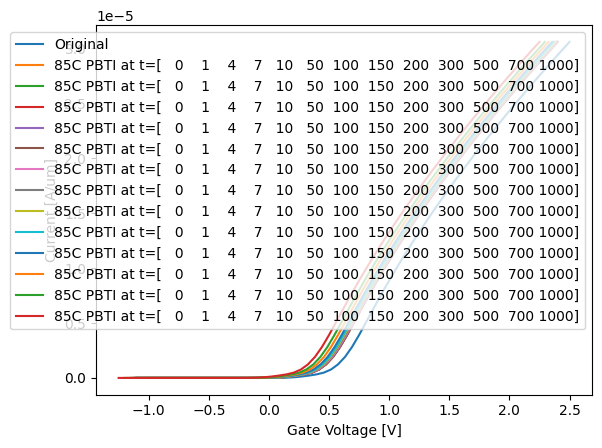

In [7]:
idvg_temp = pd.read_csv(r'/content/drive/MyDrive/Colab_ML_ProfYu/csv_data/042324_DG_IWO_Lg50nm_IV.csv', encoding='utf8')
Vg_test = np.array(idvg_temp.iloc[:, 0])
print(Vg_test)
#t = np.arange(0, 1001, 100)  # Time from 0 to 1000 by intervals of 100s]
t = np.array([0, 1, 4, 7, 10, 50, 100, 150, 200, 300, 500, 700, 1000])
print(len(t))
#delta_Vg_m15_ = [0, 0, 0, 0, 0, 0, 0.00259844729997958, -0.000457053125252409, -0.0103, -0.0197, -0.0307, ]
delta_Vg_m15 = -0.02 / 1000 * t
delta_Vg_25 = -0.05 / 1000 * t
delta_Vg_85 = -0.15 / 1000 * t - 0.1
#print(delta_Vg_m15)
# Subtract delta_Vg from Vg_test for each time step
#Vg_modified_m15 = np.array([Vg_test + delta for delta in delta_Vg_m15])
#print(Vg_modified_m15)
Vg_modified_m15 = np.array([Vg_test + delta for delta in delta_Vg_25])
Vg_modified_25 = np.array([Vg_test + delta for delta in delta_Vg_m15])
Vg_modified_85 = np.array([Vg_test + delta for delta in delta_Vg_85])
Vg_modified_vstack = np.vstack((Vg_modified_m15, Vg_modified_25, Vg_modified_85))
print(Vg_modified_vstack)

#Id0_test = np.array(idvg_temp.iloc[:, 243])
#print("Id0_test: {}".format(Vg_modified_vstack))
plt.plot(Vg_test, (Id0_test), label = "Original") ## TCAD
for i in range(len(t)):
    plt.plot(Vg_modified_85[i][:], Id0_test, label = "85C PBTI at t={}".format(t)) ## TCAD
    #plt.plot(Vg_modified_85[i][:], Id85_test, label = "85C PBTI") ## TCAD
#plt.scatter(Vg_test, np.log10(Id2_test), label = "VD = 2.4V") ## TCAD
#plt.plot(vd_temp, np.log10(Id0_test), label = "VD = 0.05V")
#plt.plot(vd_temp, np.log10(Id_test), label = "VD = 1V")
#plt.plot(vd_temp, np.log10(Id2_test), label = "VD = 2.4V")
plt.xlabel("Gate Voltage [V]")
plt.ylabel("Current [A/um]")
plt.legend()
plt.show()


In [8]:
import numpy as np
import pandas as pd

df = pd.read_csv(r'/content/drive/MyDrive/Colab_ML_ProfYu/csv_data/042324_DG_IWO_Lg50nm_IV.csv', encoding='utf8')
print(df.shape)
#df = df.iloc[:, :60]
#df.to_csv('/content/drive/MyDrive/Colab_ML_ProfYu/csv_data/IV_BTI_baseset.csv', index=False)
#print(df.shape)

# Select only even columns (0-indexed, so it's actually odd columns)
replicated_df = pd.concat([df] * len(t) * 3, axis=1) # ts 5 * temp 2
print(replicated_df.shape)
replicated_df.to_csv('/content/drive/MyDrive/Colab_ML_ProfYu/csv_data/extended_BTI_dataframe.csv', index=False)

(61, 54)
(61, 2106)


In [9]:
lch = [0.05]
vd_temp=np.array([0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5])
print(len(lch))
print(len(vd_temp))
print(t)

1
27
[   0    1    4    7   10   50  100  150  200  300  500  700 1000]


In [10]:
replicated_data = pd.read_csv(r'/content/drive/MyDrive/Colab_ML_ProfYu/csv_data/extended_BTI_dataframe.csv', encoding='utf8')
num_rows_vg_modified = Vg_modified_vstack.shape[0]

# Number of columns in each block of replicated_data
columns_per_block = 54

# Iterate over each row in Vg_modified
for row_index in range(num_rows_vg_modified):
    # Calculate the starting column index for the current block in replicated_data
    start_col_index = row_index * columns_per_block

    # Iterate over each column in the block that needs to be modified
    for col_offset in range(0, 54, 2):  # 0, 2, 4, ..., 238
        # Calculate the actual column index in replicated_data to be modified
        col_index = start_col_index + col_offset

        # Replace the specified column in replicated_data with the current row from Vg_modified
        replicated_data.iloc[:, col_index] = Vg_modified_vstack[row_index, :]

# Optionally, save the modified DataFrame to a new CSV file
replicated_data.to_csv('/content/drive/MyDrive/Colab_ML_ProfYu/csv_data/final_dataframe.csv', index=False)


In [ ]:
print(replicated_data.shape)
print(Vg_modified_vstack[5,:])
print(replicated_data.iloc[:,9*54+52])

(61, 1080)
[-1.005      -0.94666667 -0.88833333 -0.83       -0.77166667 -0.71333333
 -0.655      -0.59666667 -0.53833333 -0.48       -0.42166667 -0.36333333
 -0.305      -0.24666667 -0.18833333 -0.13       -0.07166667 -0.01333333
  0.045       0.10333333  0.16166667  0.22        0.27833333  0.33666667
  0.395       0.45333333  0.51166667  0.57        0.62833333  0.68666667
  0.745       0.80333333  0.86166667  0.92        0.97833333  1.0366667
  1.095       1.1533333   1.2116667   1.27        1.3283333   1.3866667
  1.445       1.5033333   1.5616667   1.62        1.6783333   1.7366667
  1.795       1.8533333   1.9116667   1.97        2.0283333   2.0866667
  2.145       2.2033333   2.2616667   2.32        2.3783333   2.4366667
  2.495     ]
0    -1.050000
1    -0.991667
2    -0.933333
3    -0.875000
4    -0.816667
        ...   
56    2.216667
57    2.275000
58    2.333333
59    2.391667
60    2.450000
Name: drain TotalCurrent(IdVgdg_n97_des) X.9, Length: 61, dtype: float64


In [ ]:
import numpy as np
import pandas as pd
original_data = pd.read_csv(r'/content/drive/MyDrive/Colab_ML_ProfYu/csv_data/BTI_training_data_1.csv', encoding='utf8')
trimmed_data = original_data.iloc[:, :8640]
rows_to_retain = [0, 4, 12, 16, 21]
final_data = trimmed_data.iloc[rows_to_retain, :]
final_data.to_csv('/content/drive/MyDrive/Colab_ML_ProfYu/csv_data/modified_dataframe.csv', index=False)

In [ ]:
from re import L
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

from torch import optim
from torch.utils import data
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt


import statistics
import datetime
import os
import csv
import math
import time
import numpy as np
import os

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Record the start time
start_time = time.time()

os.getcwd()

start = time.time()

idvg_temp = pd.read_csv(r'/content/drive/MyDrive/Colab_ML_ProfYu/csv_data/final_dataframe.csv', encoding='utf8')

vov = [0.5, 1.0, 1.7]
vd_temp=[0.01, 0.012, 0.015, 0.018, 0.022, 0.027, 0.034, 0.041, 0.050, 0.062, 0.075, 0.092, 0.113, 0.138, 0.169, 0.207, 0.253, 0.310, 0.379, 0.464, 0.568, 0.695, 0.851, 1.042, 1.275, 1.560, 1.9600, 2.337, 2.86, 3.4]
temperature = [25.0, 85.0]
stress_time = list(np.arange(1, 1001, 100))
vd = np.array(vd_temp)
vg_temp=idvg_temp.iloc[:,0]
vg = np.array(vg_temp.values)
vov = np.array(vov)


def Logset(target):
    temp = np.array(target)
    # temp[temp<0]=abs(temp)
    # temp = temp.tolist() not use
    temp = np.log10(temp)
    return temp

It = []
for t in list(range(len(temperature))):
    for s in list(range(len(stress_time))):
        for l in list(range(len(vov))):
            for i in list(range(len(vd))):
                col_index = i + len(vd) * (l + len(vov) * (s + len(stress_time) * t))
                temp = idvg_temp.iloc[:, col_index]
                temp = np.array(temp.values)
                It.extend(temp)

It = Logset(It)
It[np.isnan(It)] = 0
# vd = Logset(vd)
def normaliz(target): #Minmax normalization
    Min = min(target)
    Val = target-Min
    Val = Val
    Max = max(Val)
    Norm = 1/Max
    return (Norm, Val, Min)

(normVg, Vg_1, MinVg)=normaliz(vg)
(normVd, Vd_1, MinVd)=normaliz(vd)
(normIt, It_1, MinIt)=normaliz(It)
(normv_ov, Vov_1, MinVov) = normaliz(vov)
(normtemperature, temperature_1, Mintemperature) = normaliz(temperature)
(normstress_time, stress_time_1, Minstress_time) = normaliz(stress_time)

Vg = normVg*Vg_1
Vd = normVd*Vd_1
I = normIt*It_1
Vov = normVov*Vov_1
temperature = normtemperature*temperature_1
stress_time = normstress_time*stress_time_1

datasets = []
for t in list(range(len(temperature))):
    for s in list(range(len(stress_time))):
        for l in list(range(len(Vov))):
            for i in list(range(len(vd))):
                for j in list(range(len(vg))):
                    index = j + len(vg) * (i + len(vd) * (l + len(Vov) * (s + len(stress_time) * t)))
                    temp = [vg[j], vd[i], Vov[l], temperature[t], stress_time[s], I[index]]
                    datasets.append(temp)

V = []
for i in list(range(len(datasets))):
    temp = [datasets[i][0], datasets[i][1], datasets[i][2], datasets[i][3], datasets[i][4]]
    V.append(temp)

I = []
for i in list(range(len(datasets))):
    temp = [datasets[i][5]]
    I.append(temp)

V = torch.tensor(V)
I = torch.tensor(I)

# dataset = list(zip(V, I))
x_train, x_test, y_train, y_test = train_test_split(V, I, test_size=0.1, random_state=41)
dataset = TensorDataset(x_train, y_train)
dataloader = DataLoader(dataset, batch_size = 32)
testdataloader = DataLoader(TensorDataset(x_test, y_test))

# print(idvg_temp.values)
It_g = [10**x for x in It]
CM_git = np.corrcoef(vg,It_g[len(vg)*10:len(vg)*11])
Itd=[]
print(len(It_g))
print(len(vg))
print(len(vd))
print(len(Vov))

for i in list(range(len(vd))):
    Itd.append(It_g[len(vg)-23+len(vg)*i])
print(Itd)
CM_dit = np.corrcoef(vd, Itd)

print(Vov)
print()
Itl = []
print(It_g[len(vg)*len(vd)-4])
print(It_g[len(vg)*len(vd)*8-4])
print(list(range(len(vov))))
for i in list(range(len(vov))):
    Itl.append(It[len(vg)*len(vd)*(i+1)-20] )
print(Itl)
CM_lit = np.corrcoef(Vov, Itl)

print(CM_git)
print(CM_dit)
print(CM_lit)

# Define the neural network class
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(5, 40)
        self.fc2 = torch.nn.Linear(40, 25)
        self.fc3 = torch.nn.Linear(25, 1)
        self.dropout = torch.nn.Dropout(0.1)
        self.tanh = torch.nn.Tanh()
        self.bn1 = torch.nn.BatchNorm1d(40)
        self.bn2 = torch.nn.BatchNorm1d(25)
        self.bn3 = torch.nn.BatchNorm1d(1)

    def forward(self, x):
        x = self.fc1(x)
        #x = self.bn1(x)
        x = self.tanh(x)
        #x = self.dropout(x)
        x = self.fc2(x)
        #x = self.bn2(x)
        x = self.tanh(x)
        #x = self.dropout(x)
        x = self.fc3(x)
        #x = self.bn3(x)
        return x

# Create an instance of the MLP class
model = MLP()

#torch.nn.init.xavier_uniform(model.fc1.weight)
#torch.nn.init.xavier_uniform(model.fc2.weight)
#torch.nn.init.xavier_uniform(model.fc3.weight)
# torch.nn.init.xavier_uniform(model.fc4.weight)
def initialize_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)

model.apply(initialize_weights)

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

nb_epochs = 2
MLoss = []
for epoch in range(0, nb_epochs):

    current_loss = 0.0
    losses = []
    # Iterate over the dataloader for training data
    for i, data in enumerate(dataloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0],1))

        #zero the gradients
        optimizer.zero_grad()

        #perform forward pass
        outputs = model(inputs)
        L_weight = 3
        #compute loss
        batch_loss = []
        for j in range(inputs.size(0)):
            input_j = inputs[j].reshape((1, inputs.shape[1]))
            if input_j[0,0]>0.3:
                batch_loss.append(L_weight*loss_function(outputs[j], targets[j]))
            else:
                batch_loss.append(loss_function(outputs[j], targets[j]))

        loss = torch.stack(batch_loss).mean()

        losses.append(loss.item())

        #perform backward pass
        loss.backward()
        #perform optimization
        optimizer.step()
        # Print statistics

    mean_loss = sum(losses)/len(losses)
    scheduler.step(mean_loss)

    print('Loss (epoch: %4d): %.8f' %(epoch+1, mean_loss))
# Print the loss only every 10 epochs
    #if (epoch + 1) % 10 == 0:
    #    print('Loss (epoch: %4d): %.8f' % (epoch + 1, mean_loss))
    current_loss = 0.0
    MLoss.append(mean_loss)

    #optimizer.step()
        # Print statistics
    #mean_loss = sum(losses) / len(losses)
    #scheduler.step(mean_loss)


# Process is complete.
print('Training process has finished.')

torch.save(model, 'IWO_idvg.pt')
torch.save(model.state_dict(), 'IWO_idvg_state_dict.pt')

####### loss vs. epoch #######
xloss = list(range(0, nb_epochs))
plt.plot(xloss, np.log10(MLoss))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
"""
plt.plot(xloss[500:], MLoss[500:])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

with torch.no_grad():

    output = []
    # Iterate over the dataloader for training data
    for i, data in enumerate(testdataloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0],1))

        #zero the gradients
        optimizer.zero_grad()

        #perform forward pass
        outputs = model(inputs)
        output.append(outputs)
# Process is complete.
print('Training process has finished.')

output1 = np.power(10, output/normIt+MinIt)
ytest1 = np.power(10, y_test/normIt+MinIt)
plt.scatter(np.log10(output1), np.log10(ytest1))
a = [min(ytest1), max(ytest1)]
b = [min(ytest1), max(ytest1)]
plt.plot(np.log10(a), np.log10(b), 'k')
plt.plot(np.log10(a), np.log10(b), 'k')

plt.xlabel("TCAD [A/um]")
plt.ylabel("ML-Prediction [A/um]")
plt.show()

plt.plot(a,b,'k')
plt.scatter(ytest1,output1)
plt.xlabel("TCAD [A/um]")
plt.ylabel("ML-Prediction [A/um]")
plt.show()


answer_test = [i for sublist in ytest1.tolist() for i in sublist]
print(answer_test)
print(output1)

######################### IDVD Vg=0.8 ##############################
x_test = np.linspace(0.01, 3.4, num=30)
print(x_test)
# x_test = Logset(x_test.tolist())
X= []
# X =[[((x_test[i]/10)-MinV)*normV for i in list(range(len(x_test)))]]
for i in list(range(len(x_test))):
    temp=[(0.8-MinVg)*normVg, (x_test[i]-MinVd)*normVd, 0]
    X.append(temp)

Pred_y=[]
for i in list(range(len(x_test))):
    new_var =  torch.FloatTensor(X[i])
    pred_y=model(new_var).data.numpy()
    # Tolist=pred_y.tolist()
    Pred_y.append(pred_y)

I_pred =[np.power(10, i/normIt+MinIt) for i in Pred_y]

I_pred=np.array(I_pred)

I_final= []
for i in list(range(len(I_pred))):
    I_final.extend(I_pred[i])

######################### vg=1.7 IDVD ##############################

X1= []
# X =[[((x_test[i]/10)-MinV)*normV for i in list(range(len(x_test)))]]
for i in list(range(len(x_test))):
    temp=[(1.7-MinVg)*normVg, (x_test[i]-MinVd)*normVd, 0]
    X1.append(temp)

Pred_y1=[]
for i in list(range(len(x_test))):
    new_var =  torch.FloatTensor(X1[i])
    pred_y15=model(new_var).data.numpy()
    # Tolist=pred_y.tolist()
    Pred_y1.append(pred_y15)

I_pred1 =[np.power(10, i/normIt+MinIt) for i in Pred_y1]

I_pred1=np.array(I_pred1)

I_final1= []
for i in list(range(len(I_pred1))):
    I_final1.extend(I_pred1[i])

    ######################### vg=2.6 IDVD ##############################

X15= []
# X =[[((x_test[i]/10)-MinV)*normV for i in list(range(len(x_test)))]]
for i in list(range(len(x_test))):
    temp=[(2.6-MinVg)*normVg, (x_test[i]-MinVd)*normVd, 0]
    X15.append(temp)

Pred_y15=[]
for i in list(range(len(x_test))):
    new_var =  torch.FloatTensor(X15[i])
    pred_y15=model(new_var).data.numpy()
    # Tolist=pred_y.tolist()
    Pred_y15.append(pred_y15)

I_pred15 =[np.power(10, i/normIt+MinIt) for i in Pred_y15]

I_pred15=np.array(I_pred15)

I_final15= []
for i in list(range(len(I_pred15))):
    I_final15.extend(I_pred15[i])

############# Vg = 3.5 IDVD ######################

X25= []
# X =[[((x_test[i]/10)-MinV)*normV for i in list(range(len(x_test)))]]
for i in list(range(len(x_test))):
    temp=[(3.5-MinVg)*normVg, (x_test[i]-MinVd)*normVd, 0]
    X25.append(temp)

Pred_y25=[]
for i in list(range(len(x_test))):
    new_var =  torch.FloatTensor(X25[i])
    pred_y25=model(new_var).data.numpy()
    # Tolist=pred_y.tolist()
    Pred_y25.append(pred_y25)

I_pred25 =[np.power(10, i/normIt+MinIt) for i in Pred_y25]

I_pred25=np.array(I_pred25)

I_final25= []
for i in list(range(len(I_pred25))):
    I_final25.extend(I_pred25[i])

#
Vd_test = [0.01, 0.012, 0.015, 0.018, 0.022, 0.027, 0.034, 0.041, 0.050, 0.062, 0.075, 0.092, 0.113, 0.138, 0.169, 0.207, 0.253, 0.310, 0.379, 0.464, 0.568, 0.695, 0.851, 1.042, 1.275, 1.560, 1.9600, 2.337, 2.86, 3.4]

Id05_test =   [0.000002334528,	0.000002794075,	0.0000034787794,	0.0000041579335,	0.0000050547895,	0.0000061619935,	0.0000076860329,	0.0000091797256,	0.00001105585,	0.000013479929,	0.000016007828,	0.000019161787,	0.000022833255,	0.000026916777,	0.000031624447,	0.00003715309,	0.000043519255,	0.000051091182,	0.000059951515,	0.000070285433,	0.000081658741,	0.00009342872,	0.00010362595,	0.00011101203,	0.00011523482,	0.00011676641,	0.00011730475,	0.00011770665,	0.00011801129,	0.00011824027]
Id1_test = [0.0000068904883,	0.0000082636631,	0.000010320372,	0.000012373432,	0.000015105188,	0.000018510854,	0.000023262079,	0.000027993958,	0.000034049704,	0.000042075633,	0.000050709182,	0.000061905496,	0.000075594373,	0.000091696572,	0.0001113915,	0.0001351759,	0.00016354498,	0.00019827644,	0.00024007196,	0.00029160991,	0.00035507471,	0.00043267721,	0.00052608063,	0.00063305815,	0.0007463102,	0.0008524028,	0.00094690883,	0.0010169456,	0.0010548491,	0.0010714827]
Id15_test = [0.000010230849,	0.000012273384,	0.000015334923,	0.000018393846,	0.000022468346,	0.000027555048,	0.000034664693,	0.000041761002,	0.000050865865,	0.00006297397,	0.000076052026,	0.000093097636,	0.0001140765,	0.00013895091,	0.00016967963,	0.00020724046,	0.00025268947,	0.00030923446,	0.00037849644,	0.00046572552,	0.00057601516,	0.00071607664,	0.00089446014,	0.0011176712,	0.0013874073,	0.0016982907,	0.0020232064,	0.0023477774,	0.0026028589,	0.002758771]
Id_test =  [0.000012969341,	0.000015560565,	0.000019445809,	0.000023329203,	0.000028504135,	0.000034968453,	0.000044010611,	0.000053044062,	0.000064646594,	0.000080097706,	0.000096815121,	0.000118649,	0.00014559015,	0.00017764185,	0.00021740052,	0.0002662518,	0.00032573661,	0.0004003178,	0.00049245958,	0.00060963036,	0.00075939393,	0.00095209114,	0.0012021121,	0.0015230151,	0.0019258635,	0.0024179715,	0.0029806776,	0.003633391,	0.0042757708,	0.0047633642]

# x_test = np.power(10, x_test)

plt.scatter(Vd_test, Id05_test) ## TCAD
plt.scatter(Vd_test, Id1_test) ## TCAD
plt.scatter(Vd_test, Id15_test) ## TCAD
plt.scatter(Vd_test, Id_test) ## TCAD
plt.plot(x_test, I_final)
plt.plot(x_test, I_final1)
plt.plot(x_test, I_final15)
plt.plot(x_test, I_final25)
plt.xlabel("Drain Voltage [V]")
plt.ylabel("Current [A/um]")
plt.show()

plt.scatter(Vd_test, Id05_test) ## TCAD
plt.scatter(Vd_test, Id1_test) ## TCAD
plt.plot(x_test, I_final)
plt.plot(x_test, I_final1)
plt.xlabel("Drain Voltage [V]")
plt.ylabel("Current [A/um]")
plt.show()
print(np.round(x_test, 3).tolist)
print(I_final)
print(I_final1)
print(I_final15)
print("")

#################### IDVG #######################

xv_test = list(range(-10, 36, 1))
xv_test = np.array(xv_test)/10

(normVgtest, xv_test_1, MinVtest)=normaliz(xv_test)
Xv= []
# X =[[((x_test[i]/10)-MinV)*normV for i in list(range(len(x_test)))]]
for i in list(range(len(xv_test_1))):
    temp=[(xv_test[i]-MinVg)*normVg, ((0.05)-MinVd)*normVd, 0]
    Xv.append(temp)

Predv_y=[]
for i in list(range(len(xv_test_1))):
    new_var =  torch.FloatTensor(Xv[i])
    pred_y=model(new_var).data.numpy()
    # Tolist=pred_y.tolist()
    Predv_y.append(pred_y)

Iv_pred =[np.power(10, i/normIt+MinIt) for i in Predv_y]

Iv_pred=np.array(Iv_pred)

Iv_final= []
for i in list(range(len(Iv_pred))):
    Iv_final.extend(Iv_pred[i])

#### VD =1.042V ####

Xv11=[]
for i in list(range(len(xv_test))):
    temp=[(xv_test[i]-MinVg)*normVg, ((1.042)-MinVd)*normVd, 0]
    Xv11.append(temp)

Predv_y11=[]
for i in list(range(len(xv_test))):
    new_var =  torch.FloatTensor(Xv11[i])
    pred_y11=model(new_var).data.numpy()
    Predv_y11.append(pred_y11)

Iv_pred11 =[np.power(10, i/normIt+MinIt) for i in Predv_y11]

Iv_pred11=np.array(Iv_pred11)

Iv_final11= []
for i in list(range(len(Iv_pred11))):
    Iv_final11.extend(Iv_pred11[i])

#### VD =3.4V #### 2.337

Xv25=[]
for i in list(range(len(xv_test))):
    temp=[(xv_test[i]-MinVg)*normVg, ((2.337)-MinVd)*normVd, 0]
    Xv25.append(temp)

Predv_y25=[]
for i in list(range(len(xv_test))):
    new_var =  torch.FloatTensor(Xv25[i])
    pred_y25=model(new_var).data.numpy()
    Predv_y25.append(pred_y25)

Iv_pred25 =[np.power(10, i/normIt+MinIt) for i in Predv_y25]

Iv_pred25=np.array(Iv_pred25)

Iv_final25= []
for i in list(range(len(Iv_pred25))):
    Iv_final25.extend(Iv_pred25[i])

##### below is from TCAD #####
Vg_test = [-1,	-0.87142857,	-0.74285714,	-0.61428571,	-0.48571429,	-0.35714286,	-0.22857143,	-0.1,	0.028571429,	0.15714286,	0.28571429,	0.41428571,	0.54285714,	0.67142857,	0.8,	0.92857143,	1.0571429,	1.1857143,	1.3142857,	1.4428571,	1.5714286,	1.7,	1.8285714,	1.9571429,	2.0857143,	2.2142857,	2.3428571,	2.4714286,	2.6,	2.7285714,	2.8571429,	2.9857143,	3.1142857,	3.2428571,	3.3714286,	3.5]

Id0_test = [6.0366509E-24,	8.4496776E-22,	1.1747828E-19,	1.6070645E-17,	2.1422178E-15,	2.4891875E-13,	0.000000000013962995,	0.00000000028716668,	0.0000000044495768,	0.000000052182154,	0.00000031576001,	0.0000012230809,	0.0000036792536,	0.0000071776321,	0.00001105585,	0.000015236741,	0.000018953721,	0.000022321276,	0.000025471855,	0.00002845546,	0.000031308864,	0.000034049704,	0.000036691166,	0.000039244928,	0.000041715704,	0.000044108729,	0.000046429037,	0.000048680267,	0.000050865865,	0.000052991948,	0.000055060637,	0.000057073072,	0.000059038778,	0.000060954363,	0.000062822385,	0.000064646594]
Id_test = [6.5726763E-23,	1.074733E-21,	1.5054616E-19,	2.089954E-17,	2.8457564E-15,	3.4630142E-13,	0.000000000021507479,	0.00000000047443979,	0.0000000076094844,	0.00000012160276,	0.0000013329527,	0.0000068796113,	0.000023222635,	0.000057753922,	0.00011101203,	0.00017662755,	0.0002477421,	0.00032092367,	0.00039619401,	0.00047418914,	0.00055484828,	0.00063305815,	0.00070885986,	0.00078224439,	0.00085324923,	0.00092217874,	0.0009890835,	0.0010542113,	0.0011176712,	0.0011795664,	0.0012400484,	0.0012991997,	0.0013570033,	0.0014135401,	0.00146889,	0.0015230151]
# Id2_test = [0.00000000028999272,	0.00000000024604411,	0.000000000208839,	0.00000000015892722,	0.00000000013323784,	0.00000000012752485,	0.00000000024163604,	0.0000000015000178,	0.00000001459907,	0.00000016488813,	0.0000014600513,	0.0000070961489,	0.000023578158,	0.000059393719,	0.00011824027,	0.00019892949,	0.00029982926,	0.0004191606,	0.00055617887,	0.00071067895,	0.00088251831,	0.0010714827,	0.0012768098,	0.0014977426,	0.0017292861,	0.0019734283,	0.0022272997,	0.0024898736,	0.002758771,	0.0030327668,	0.0033162884,	0.0036011479,	0.0038954135,	0.0041845065,	0.0044747038,	0.0047633642]
Id2_test = [0.000000000025494235,	0.000000000012954164,	5.0756078E-12,	1.3277786E-12,	1.9832705E-13,	3.8441706E-13,	0.000000000022061297,	0.00000000047642503,	0.0000000076135681,	0.00000012164447,	0.0000013351355,	0.0000069088198,	0.000023438983,	0.000059204515,	0.00011770665,	0.00019763123,	0.00029700373,	0.00041351776,	0.0005455993,	0.0006915413,	0.00084927227,	0.0010169456,	0.0011927032,	0.0013746856,	0.0015617533,	0.0017551156,	0.0019548531,	0.0021515877,	0.0023477774,	0.0025415313,	0.0027321298,	0.0029192402,	0.0031029262,	0.0032831873,	0.003459982,	0.003633391]

plt.scatter(Vg_test, np.log10(Id0_test)) ## TCAD
plt.scatter(Vg_test, np.log10(Id_test)) ## TCAD
plt.scatter(Vg_test, np.log10(Id2_test)) ## TCAD
plt.plot(xv_test, np.log10(Iv_final))
plt.plot(xv_test, np.log10(Iv_final11))
plt.plot(xv_test, np.log10(Iv_final25))
plt.xlabel("Gate Voltage [V]")
plt.ylabel("Current [A/um]")
plt.show()

plt.scatter(Vg_test, (Id0_test)) ## TCAD
plt.scatter(Vg_test, (Id_test)) ## TCAD
plt.scatter(Vg_test, (Id2_test)) ## TCAD
plt.plot(xv_test, (Iv_final))
plt.plot(xv_test, (Iv_final11))
plt.plot(xv_test, (Iv_final25))
plt.xlabel("Gate Voltage [V]")
plt.ylabel("Current [A/um]")
plt.show()

print(xv_test)
print(Iv_final)
print(Iv_final11)
print(Iv_final25)
print("")

# Instantiate the PyTorch model
model.load_state_dict(torch.load('IWO_idvg_state_dict.pt'))
"""
# Extract the weights and biases from the model
weights_1 = model.fc1.weight.detach().numpy()
bias_1 = model.fc1.bias.detach().numpy()
weights_2 = model.fc2.weight.detach().numpy()
bias_2 = model.fc2.bias.detach().numpy()
weights_3 = model.fc3.weight.detach().numpy()
bias_3 = model.fc3.bias.detach().numpy()

verilog_code = ""

# Create the Verilog-A code for the 1st hidden layer
verilog_code += "real h1_0, h1_1, h1_2, h1_3, h1_4, h1_5, h1_6, h1_7, h1_8, h1_9, h1_10, h1_11, h1_12, h1_13, h1_14, h1_15, h1_16, h1_17, h1_18, h1_19, h1_20, h1_21, h1_22, h1_23, h1_24, h1_25, h1_26, h1_27, h1_28, h1_29, h1_30, h1_31, h1_32, h1_33, h1_34, h1_35, h1_36, h1_37, h1_38, h1_39;\n"
for i in range(40):
    inputs = ["Vgs", "Vds", "Lg", "t_stress", "temp"]
    inputs = ["*".join([str(weights_1[i][j]), inp]) for j, inp in enumerate(inputs)]
    inputs = "+".join(inputs)
    inputs = "+".join([inputs, str(bias_1[i])])
    verilog_code += "h1_{} = tanh({});\n".format(i, inputs)

# Create the Verilog-A code for the 2nd hidden layer
verilog_code += "real h2_0, h2_1, h2_2, h2_3, h2_4, h2_5, h2_6, h2_7, h2_8, h2_9, h2_10, h2_11, h2_12, h2_13, h2_14, h2_15, h2_16, h2_17, h2_18, h2_19, h2_20, h2_21, h2_22, h2_23, h2_24;\n"
for i in range(25):
    inputs = ["h1_{}".format(j) for j in range(40)]
    inputs = ["*".join([str(weights_2[i][j]), inp]) for j, inp in enumerate(inputs)]
    inputs = "+".join(inputs)
    inputs = "+".join([inputs, str(bias_2[i])])
    verilog_code += "h2_{} = tanh({});\n".format(i, inputs)

# Create the Verilog-A code for the output layer
inputs = ["h2_{}".format(i) for i in range(25)]
inputs = ["*".join([str(weights_3[0][i]), inp]) for i, inp in enumerate(inputs)]
inputs = "+".join(inputs)
inputs = "+".join([inputs, str(bias_3[0])])
verilog_code += "y = {};\n".format(inputs)

verilog_code = """
module IWO_verilogA (d, g, s);
inout d, g, s;
electrical d, g, s;

//****** Parameters L and W ********
parameter real W = 0.1; //set on cadence
parameter real L = 0.05; //set on cadence
parameter MinVg = {} ;
parameter normVg = {} ;
parameter MinVd = {} ;
parameter normVd = {} ;
parameter MinLg = {} ;
parameter normLg = {} ;
parameter MinI = {} ;
parameter normI = {};

real Vg, Vd, Vs, Vgs, Vds, Lg, Id, Cgg, Cgsd, Vgd;
real Vgsraw, Vgdraw, dir;
real t_stress, temp;
// stress time, temperature
// t_stress = 0 to 1000, temp = 25C or 85C

analog begin
	Vg = V(g);
	Vs = V(s);
	Vd = V(d);
    Vgsraw = Vg-Vs ;
    Vgdraw = Vg-Vd ;
if (Vgsraw>=Vgdraw) begin
	Vgs = ((Vg-Vs) - MinVg) * normVg ;
    dir = 1 ;
end
else begin
	Vgs = ((Vg-Vd) - MinVg) * normVg ;
    dir = -1 ;
end
	Vds = (abs(Vd-Vs) - MinVd) * normVd ;
	Lg = (L -MinLg)*normLg ;


{}

Id = pow(10, (y/normI + MinI))*W;
I(g, d) <+ Cgsd*ddt(Vg-Vd) ;
I(g, s) <+ Cgsd*ddt(Vg-Vs) ;

if (Vd >= Vs) begin
	I(d, s) <+ dir*Id;
end

else begin
	I(d, s) <+ dir*Id;
end

end
endmodule

""".format(MinVg, normVg, MinVd, normVd, MinVov, normVov, MinIt, normIt, verilog_code)

print(verilog_code)

with open("iwo_test.va", "w") as f:
    f.write(verilog_code)

# Record the end time
end_time = time.time()

# Calculate the total time taken
time_taken = end_time - start_time

print(f"Time taken: {time_taken} seconds")

<ipython-input-1-cf86cb726e79>:54: RuntimeWarning: invalid value encountered in log10
  temp = np.log10(temp)


TypeError: unsupported operand type(s) for -: 'list' and 'float'

In [ ]:
vd_temp=[0.01, 0.012, 0.015, 0.018, 0.022, 0.027, 0.034, 0.041, 0.050, 0.062, 0.075, 0.092, 0.113, 0.138, 0.169, 0.207, 0.253, 0.310, 0.379, 0.464, 0.568, 0.695, 0.851, 1.042, 1.275, 1.560, 1.9600, 2.337, 2.86, 3.4]
len(vd_temp)

30

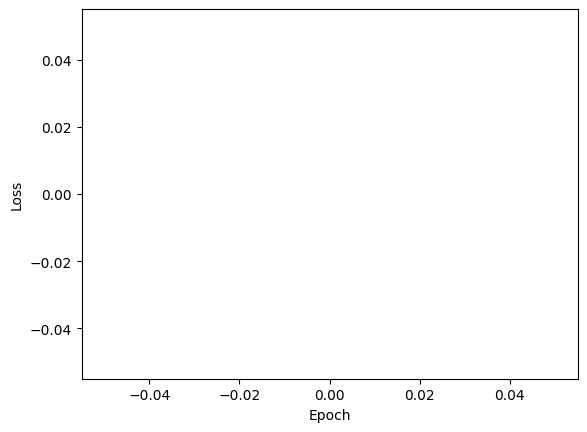

Training process has finished.


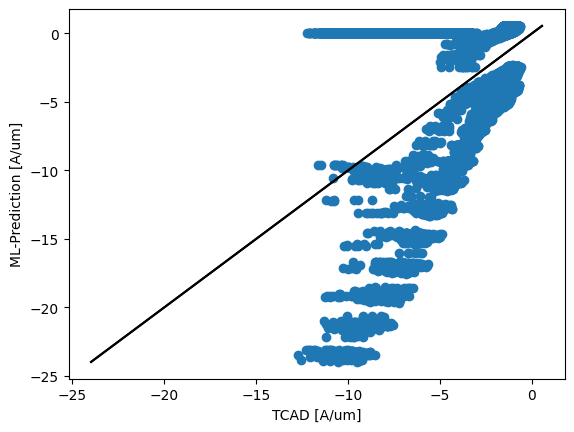

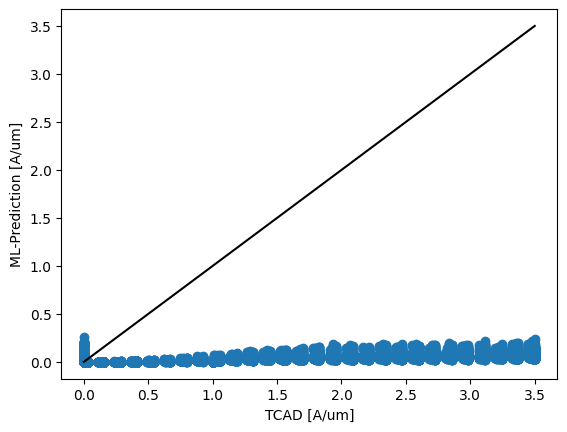

[2.6000000000000014, 5.580000000000033e-09, 0.0016901169999999953, 6.199999999999981e-05, 1.5264286000000054, 0.285714289999999, 1.0, 1.0, 3.709999999999994e-05, 1.2200000000000004e-06, 4.720000000000007e-12, 2.693571399999996, 2.0857142999999954, 3.1928570999999946, 1.0, 2.7899999999999933e-05, 0.0007050509999999993, 0.0005865250000000021, 1.0, 2.5900000000000003, 1.3100000000000032e-17, 1.4328570999999957, 2.34285709999999, 1.6999999999999937, 0.0002086300000000007, 1.2900000000000022e-15, 5.150000000000007e-20, 2.300000000000001e-06, 0.00014832499999999934, 0.0006265849999999997, 2e-05, 2.560000000000003e-15, 0.0285714289999999, 2.0857142999999954, 0.4142857100000014, 0.6714285699999982, 0.00029982899999999934, 1.8285714000000064, 1.2692857000000013, 6.9100000000000296e-06, 2.060714300000002, 5.490000000000005e-16, 2.8571428999999897, 1.5664286000000027, 5.029999999999999e-05, 1.4100000000000023e-24, 1.0, 1.8285714000000064, 2.250000000000001e-13, 0.00021075099999999912, 2.199285700

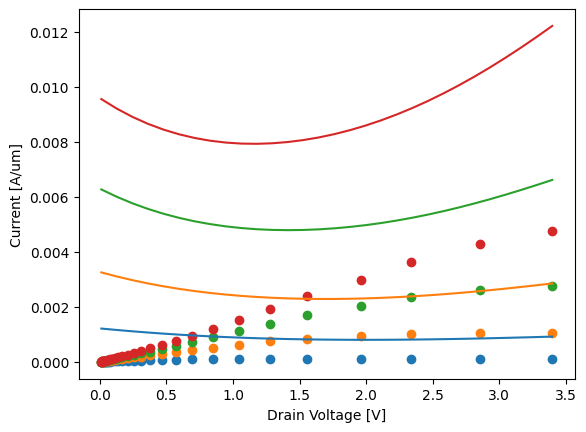

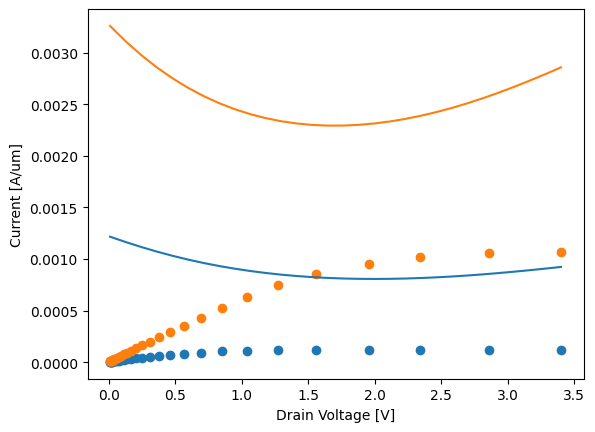

<built-in method tolist of numpy.ndarray object at 0x78973039b3f0>
[0.0012158043, 0.0011641567, 0.0011160943, 0.0010717564, 0.0010312158, 0.0009944772, 0.000961464, 0.00093207724, 0.0009061917, 0.00088367175, 0.00086435705, 0.0008480938, 0.00083473173, 0.0008241279, 0.00081611396, 0.0008105737, 0.00080736546, 0.0008063626, 0.00080744346, 0.0008104847, 0.0008153831, 0.0008220061, 0.00083024934, 0.00083999435, 0.0008511162, 0.0008634882, 0.0008769755, 0.00089144433, 0.0009067371, 0.00092270144]
[0.0032581275, 0.0031095853, 0.0029762215, 0.0028572853, 0.0027520435, 0.0026596573, 0.0025793738, 0.0025104505, 0.0024521518, 0.0024038379, 0.0023648734, 0.0023347293, 0.0023128688, 0.0022988329, 0.0022921893, 0.0022925718, 0.0022996105, 0.0023129603, 0.0023323414, 0.0023574382, 0.0023879805, 0.002423661, 0.0024642, 0.002509304, 0.0025586477, 0.0026119193, 0.0026687253, 0.0027286953, 0.0027914224, 0.002856407]
[0.00627546, 0.006007004, 0.0057718414, 0.0055674585, 0.0053914865, 0.00524187, 0.00511

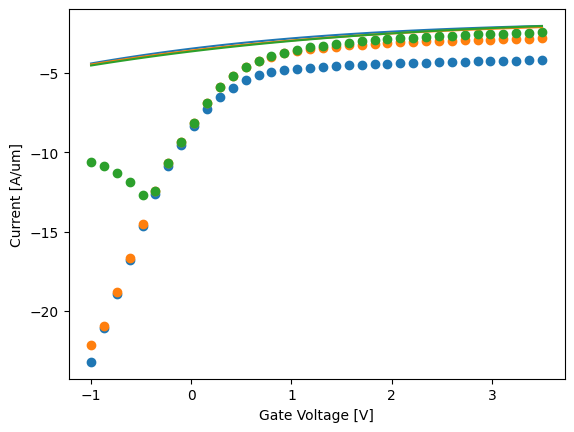

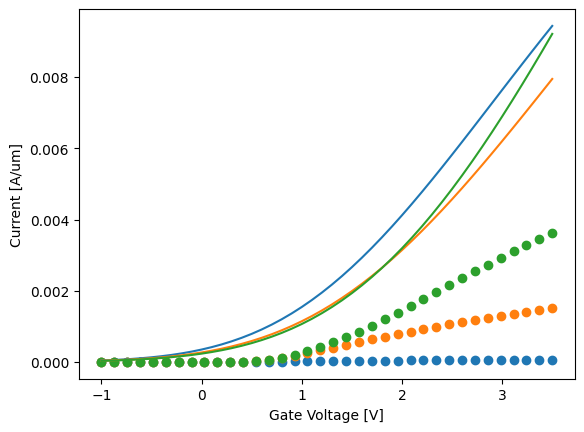

[-1.  -0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3
  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3  1.4  1.5  1.6  1.7
  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7  2.8  2.9  3.   3.1
  3.2  3.3  3.4  3.5]
[4.0409323e-05, 5.1822182e-05, 6.594233e-05, 8.3265935e-05, 0.00010434708, 0.00012979397, 0.0001602696, 0.00019648061, 0.0002391822, 0.00028915843, 0.0003472176, 0.00041418392, 0.0004908755, 0.0005781101, 0.00067665614, 0.0007872565, 0.0009105801, 0.00104724, 0.0011977424, 0.0013625119, 0.001541862, 0.0017359768, 0.0019449224, 0.002168649, 0.0024069436, 0.002659517, 0.0029259096, 0.003205555, 0.003497782, 0.0038018266, 0.0041168123, 0.0044417726, 0.0047757635, 0.0051176455, 0.005466376, 0.005820717, 0.0061797076, 0.0065420503, 0.0069067455, 0.0072726137, 0.007638616, 0.008003752, 0.008367027, 0.008727528, 0.009084471, 0.009436928]
[3.478617e-05, 4.3881988e-05, 5.4983993e-05, 6.843729e-05, 8.462633e-05, 0.00010397243, 0.0001269353, 0.00015400955, 0.0001857

<All keys matched successfully>

In [ ]:
#plt.plot(xloss[500:], MLoss[500:])
#plt.xlabel("Epoch")
#plt.ylabel("Loss")
#plt.show()

with torch.no_grad():

    output = []
    # Iterate over the dataloader for training data
    for i, data in enumerate(testdataloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0],1))

        #zero the gradients
        optimizer.zero_grad()

        #perform forward pass
        outputs = model(inputs)
        output.append(outputs)
# Process is complete.
print('Training process has finished.')

output1 = np.power(10, output/normIt+MinIt)
ytest1 = np.power(10, y_test/normIt+MinIt)
plt.scatter(np.log10(output1), np.log10(ytest1))
a = [min(ytest1), max(ytest1)]
b = [min(ytest1), max(ytest1)]
plt.plot(np.log10(a), np.log10(b), 'k')
plt.plot(np.log10(a), np.log10(b), 'k')

plt.xlabel("TCAD [A/um]")
plt.ylabel("ML-Prediction [A/um]")
plt.show()

plt.plot(a,b,'k')
plt.scatter(ytest1,output1)
plt.xlabel("TCAD [A/um]")
plt.ylabel("ML-Prediction [A/um]")
plt.show()


answer_test = [i for sublist in ytest1.tolist() for i in sublist]
#print(answer_test)
#print(output1)

######################### IDVD Vg=0.8 ##############################
x_test = np.linspace(0.01, 3.4, num=30)
#print(x_test)
# x_test = Logset(x_test.tolist())
X= []
# X =[[((x_test[i]/10)-MinV)*normV for i in list(range(len(x_test)))]]
for i in list(range(len(x_test))):
    temp=[(0.8-MinVg)*normVg, (x_test[i]-MinVd)*normVd, 0, (1000-Minstress_time)*normstress_time, (85 - Mintemperature) * normtemperature]
    X.append(temp)

Pred_y=[]
for i in list(range(len(x_test))):
    new_var =  torch.FloatTensor(X[i])
    pred_y=model(new_var).data.numpy()
    # Tolist=pred_y.tolist()
    Pred_y.append(pred_y)

I_pred =[np.power(10, i/normIt+MinIt) for i in Pred_y]

I_pred=np.array(I_pred)

I_final= []
for i in list(range(len(I_pred))):
    I_final.extend(I_pred[i])

######################### vg=1.7 IDVD ##############################

X1= []
# X =[[((x_test[i]/10)-MinV)*normV for i in list(range(len(x_test)))]]
for i in list(range(len(x_test))):
    temp=[(1.7-MinVg)*normVg, (x_test[i]-MinVd)*normVd, 0, (1000-Minstress_time)*normstress_time, (85 - Mintemperature) * normtemperature]
    X1.append(temp)

Pred_y1=[]
for i in list(range(len(x_test))):
    new_var =  torch.FloatTensor(X1[i])
    pred_y15=model(new_var).data.numpy()
    # Tolist=pred_y.tolist()
    Pred_y1.append(pred_y15)

I_pred1 =[np.power(10, i/normIt+MinIt) for i in Pred_y1]

I_pred1=np.array(I_pred1)

I_final1= []
for i in list(range(len(I_pred1))):
    I_final1.extend(I_pred1[i])

    ######################### vg=2.6 IDVD ##############################

X15= []
# X =[[((x_test[i]/10)-MinV)*normV for i in list(range(len(x_test)))]]
for i in list(range(len(x_test))):
    temp=[(2.6-MinVg)*normVg, (x_test[i]-MinVd)*normVd, 0, (1000-Minstress_time)*normstress_time, (85 - Mintemperature) * normtemperature]
    X15.append(temp)

Pred_y15=[]
for i in list(range(len(x_test))):
    new_var =  torch.FloatTensor(X15[i])
    pred_y15=model(new_var).data.numpy()
    # Tolist=pred_y.tolist()
    Pred_y15.append(pred_y15)

I_pred15 =[np.power(10, i/normIt+MinIt) for i in Pred_y15]

I_pred15=np.array(I_pred15)

I_final15= []
for i in list(range(len(I_pred15))):
    I_final15.extend(I_pred15[i])

############# Vg = 3.5 IDVD ######################

X25= []
# X =[[((x_test[i]/10)-MinV)*normV for i in list(range(len(x_test)))]]
for i in list(range(len(x_test))):
    temp=[(3.5-MinVg)*normVg, (x_test[i]-MinVd)*normVd, 0, (1000-Minstress_time)*normstress_time, (85 - Mintemperature) * normtemperature]
    X25.append(temp)

Pred_y25=[]
for i in list(range(len(x_test))):
    new_var =  torch.FloatTensor(X25[i])
    pred_y25=model(new_var).data.numpy()
    # Tolist=pred_y.tolist()
    Pred_y25.append(pred_y25)

I_pred25 =[np.power(10, i/normIt+MinIt) for i in Pred_y25]

I_pred25=np.array(I_pred25)

I_final25= []
for i in list(range(len(I_pred25))):
    I_final25.extend(I_pred25[i])

#
Vd_test = [0.01, 0.012, 0.015, 0.018, 0.022, 0.027, 0.034, 0.041, 0.050, 0.062, 0.075, 0.092, 0.113, 0.138, 0.169, 0.207, 0.253, 0.310, 0.379, 0.464, 0.568, 0.695, 0.851, 1.042, 1.275, 1.560, 1.9600, 2.337, 2.86, 3.4]

Id05_test =   [0.000002334528,	0.000002794075,	0.0000034787794,	0.0000041579335,	0.0000050547895,	0.0000061619935,	0.0000076860329,	0.0000091797256,	0.00001105585,	0.000013479929,	0.000016007828,	0.000019161787,	0.000022833255,	0.000026916777,	0.000031624447,	0.00003715309,	0.000043519255,	0.000051091182,	0.000059951515,	0.000070285433,	0.000081658741,	0.00009342872,	0.00010362595,	0.00011101203,	0.00011523482,	0.00011676641,	0.00011730475,	0.00011770665,	0.00011801129,	0.00011824027]
Id1_test = [0.0000068904883,	0.0000082636631,	0.000010320372,	0.000012373432,	0.000015105188,	0.000018510854,	0.000023262079,	0.000027993958,	0.000034049704,	0.000042075633,	0.000050709182,	0.000061905496,	0.000075594373,	0.000091696572,	0.0001113915,	0.0001351759,	0.00016354498,	0.00019827644,	0.00024007196,	0.00029160991,	0.00035507471,	0.00043267721,	0.00052608063,	0.00063305815,	0.0007463102,	0.0008524028,	0.00094690883,	0.0010169456,	0.0010548491,	0.0010714827]
Id15_test = [0.000010230849,	0.000012273384,	0.000015334923,	0.000018393846,	0.000022468346,	0.000027555048,	0.000034664693,	0.000041761002,	0.000050865865,	0.00006297397,	0.000076052026,	0.000093097636,	0.0001140765,	0.00013895091,	0.00016967963,	0.00020724046,	0.00025268947,	0.00030923446,	0.00037849644,	0.00046572552,	0.00057601516,	0.00071607664,	0.00089446014,	0.0011176712,	0.0013874073,	0.0016982907,	0.0020232064,	0.0023477774,	0.0026028589,	0.002758771]
Id_test =  [0.000012969341,	0.000015560565,	0.000019445809,	0.000023329203,	0.000028504135,	0.000034968453,	0.000044010611,	0.000053044062,	0.000064646594,	0.000080097706,	0.000096815121,	0.000118649,	0.00014559015,	0.00017764185,	0.00021740052,	0.0002662518,	0.00032573661,	0.0004003178,	0.00049245958,	0.00060963036,	0.00075939393,	0.00095209114,	0.0012021121,	0.0015230151,	0.0019258635,	0.0024179715,	0.0029806776,	0.003633391,	0.0042757708,	0.0047633642]

# x_test = np.power(10, x_test)

#plt.scatter(Vd_test, Id05_test) ## TCAD
#plt.scatter(Vd_test, Id1_test) ## TCAD
#plt.scatter(Vd_test, Id15_test) ## TCAD
#plt.scatter(Vd_test, Id_test) ## TCAD
plt.plot(x_test, I_final)
plt.plot(x_test, I_final1)
plt.plot(x_test, I_final15)
plt.plot(x_test, I_final25)
plt.xlabel("Drain Voltage [V]")
plt.ylabel("Current [A/um]")
plt.show()

#plt.scatter(Vd_test, Id05_test) ## TCAD
#plt.scatter(Vd_test, Id1_test) ## TCAD
plt.plot(x_test, I_final)
plt.plot(x_test, I_final1)
plt.xlabel("Drain Voltage [V]")
plt.ylabel("Current [A/um]")
plt.show()
#print(np.round(x_test, 3).tolist)
#print(I_final)
#print(I_final1)
#print(I_final15)
#print("")

#################### IDVG #######################

xv_test = list(range(-10, 36, 1))
xv_test = np.array(xv_test)/10

(normVgtest, xv_test_1, MinVtest)=normaliz(xv_test)
Xv= []
# X =[[((x_test[i]/10)-MinV)*normV for i in list(range(len(x_test)))]]
for i in list(range(len(xv_test_1))):
    temp=[(xv_test[i]-MinVg)*normVg, ((0.05)-MinVd)*normVd, 0, (1000-Minstress_time)*normstress_time, (85 - Mintemperature) * normtemperature]
    Xv.append(temp)

Predv_y=[]
for i in list(range(len(xv_test_1))):
    new_var =  torch.FloatTensor(Xv[i])
    pred_y=model(new_var).data.numpy()
    # Tolist=pred_y.tolist()
    Predv_y.append(pred_y)

Iv_pred =[np.power(10, i/normIt+MinIt) for i in Predv_y]

Iv_pred=np.array(Iv_pred)

Iv_final= []
for i in list(range(len(Iv_pred))):
    Iv_final.extend(Iv_pred[i])

#### VD =1.042V ####

Xv11=[]
for i in list(range(len(xv_test))):
    temp=[(xv_test[i]-MinVg)*normVg, ((1.042)-MinVd)*normVd, 0, (1000-Minstress_time)*normstress_time, (85 - Mintemperature) * normtemperature]
    Xv11.append(temp)

Predv_y11=[]
for i in list(range(len(xv_test))):
    new_var =  torch.FloatTensor(Xv11[i])
    pred_y11=model(new_var).data.numpy()
    Predv_y11.append(pred_y11)

Iv_pred11 =[np.power(10, i/normIt+MinIt) for i in Predv_y11]

Iv_pred11=np.array(Iv_pred11)

Iv_final11= []
for i in list(range(len(Iv_pred11))):
    Iv_final11.extend(Iv_pred11[i])

#### VD =3.4V #### 2.337

Xv25=[]
for i in list(range(len(xv_test))):
    temp=[(xv_test[i]-MinVg)*normVg, ((2.337)-MinVd)*normVd, 0, (1000-Minstress_time)*normstress_time, (85 - Mintemperature) * normtemperature]
    Xv25.append(temp)

Predv_y25=[]
for i in list(range(len(xv_test))):
    new_var =  torch.FloatTensor(Xv25[i])
    pred_y25=model(new_var).data.numpy()
    Predv_y25.append(pred_y25)

Iv_pred25 =[np.power(10, i/normIt+MinIt) for i in Predv_y25]

Iv_pred25=np.array(Iv_pred25)

Iv_final25= []
for i in list(range(len(Iv_pred25))):
    Iv_final25.extend(Iv_pred25[i])

##### below is from TCAD #####
Vg_test = list(idvg_temp.iloc[:, 0])
Id0_test = list(idvg_temp.iloc[:, 17]) #VD = 0.05V
Id_test = list(idvg_temp.iloc[:, 47]) #VD = 1.042V
Id2_test = list(idvg_temp.iloc[:, 115]) #VD = 3.4V

#plt.scatter(Vg_test, np.log10(Id0_test)) ## TCAD
#plt.scatter(Vg_test, np.log10(Id_test)) ## TCAD
#plt.scatter(Vg_test, np.log10(Id2_test)) ## TCAD
plt.plot(xv_test, np.log10(Iv_final))
plt.plot(xv_test, np.log10(Iv_final11))
plt.plot(xv_test, np.log10(Iv_final25))
plt.xlabel("Gate Voltage [V]")
plt.ylabel("Current [A/um]")
plt.show()

#plt.scatter(Vg_test, (Id0_test)) ## TCAD
#plt.scatter(Vg_test, (Id_test)) ## TCAD
#plt.scatter(Vg_test, (Id2_test)) ## TCAD
plt.plot(xv_test, (Iv_final))
plt.plot(xv_test, (Iv_final11))
plt.plot(xv_test, (Iv_final25))
plt.xlabel("Gate Voltage [V]")
plt.ylabel("Current [A/um]")
plt.show()

#print(xv_test)
#print(Iv_final)
#print(Iv_final11)
#print(Iv_final25)
#print("")

# Instantiate the PyTorch model
model.load_state_dict(torch.load('IWO_idvg_state_dict.pt'))


In [ ]:
# Pruning
from re import L
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

from torch import optim
from torch.utils import data
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.utils.prune as prune
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt

import statistics
import datetime
import os
import csv
import math
import time
import numpy as np
import os

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Record the start time
start_time = time.time()

os.getcwd()

start = time.time()

idvg_temp = pd.read_csv(r'./PBTI_Variation.csv', encoding='utf8')

lch = [0.05, 0.055, 0.06, 0.065, 0.07, 0.075, 0.08, 0.09]
vd_temp=[0.01, 0.012, 0.015, 0.018, 0.022, 0.027, 0.034, 0.041, 0.050, 0.062, 0.075, 0.092, 0.113, 0.138, 0.169, 0.207, 0.253, 0.310, 0.379, 0.464, 0.568, 0.695, 0.851, 1.042, 1.275, 1.560, 1.9600, 2.337, 2.86, 3.4]
temperature = np.array([25.0, 85.0])
stress_time = np.arange(0, 1001, 100)
vd = np.array(vd_temp)
vg_temp=idvg_temp.iloc[:,0]
vg = np.array(vg_temp.values)
lch = np.array(lch)


def Logset(target):
    temp = np.array(target)
    # temp[temp<0]=abs(temp)
    # temp = temp.tolist() not use
    temp = np.log10(temp)
    return temp

It = []
for t in list(range(len(temperature))):
    for s in list(range(len(stress_time))):
        for l in list(range(len(lch))):
            for i in list(range(len(vd))):
                col_index = 2*i + 1 + 2*len(vd)*l + 2*len(vd)*len(lch)*s + 2*len(vd)*len(lch)*len(stress_time)*t
                temp = idvg_temp.iloc[:, col_index]
                temp = np.array(temp.values)
                It.extend(temp)

It = Logset(It)
# vd = Logset(vd)

def normaliz(target):
    Min = min(target)
    Val = target - Min
    Max = max(Val)
    if Max == 0:
        Norm = 1
    else:
        Norm = 1 / Max
    return (Norm, Val, Min)

(normVg, Vg_1, MinVg)=normaliz(vg)
(normVd, Vd_1, MinVd)=normaliz(vd)
(normIt, It_1, MinIt)=normaliz(It)
(normLch, Lch_1, MinLch) = normaliz(lch)
(normtemperature, temperature_1, Mintemperature) = normaliz(temperature)
(normstress_time, stress_time_1, Minstress_time) = normaliz(stress_time)

Vg = normVg*Vg_1
Vd = normVd*Vd_1
I = normIt*It_1
Lch = normLch*Lch_1
temperature = normtemperature*temperature_1
stress_time = normstress_time*stress_time_1

datasets = []
for t in list(range(len(temperature))):
    for s in list(range(len(stress_time))):
        for l in list(range(len(Lch))):
            for i in list(range(len(vd))):
                for j in list(range(len(vg))):
                    index = j + len(vg) * (i + len(vd) * (l + len(Lch) * (s + len(stress_time) * t)))
                    temp = [vg[j], vd[i], Lch[l], temperature[t], stress_time[s], I[index]]
                    datasets.append(temp)

V = []
for i in list(range(len(datasets))):
    temp = [datasets[i][0], datasets[i][1], datasets[i][2], datasets[i][3], datasets[i][4]]
    V.append(temp)

I = []
for i in list(range(len(datasets))):
    temp = [datasets[i][5]]
    I.append(temp)

V = torch.tensor(V)
I = torch.tensor(I)

# dataset = list(zip(V, I))
x_train, x_test, y_train, y_test = train_test_split(V, I, test_size=0.1, random_state=41)
dataset = TensorDataset(x_train, y_train)
dataloader = DataLoader(dataset, batch_size = 32, num_workers = 40, shuffle=True, drop_last=True)
#dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=23, pin_memory=True)
testdataloader = DataLoader(TensorDataset(x_test, y_test))

#print(idvg_temp.values)
It_g = [10**x for x in It]
CM_git = np.corrcoef(vg,It_g[len(vg)*10:len(vg)*11])
Itd=[]
print(len(It_g))
print(len(vg))
print(len(vd))
print(len(lch))

for i in list(range(len(vd))):
    Itd.append(It_g[len(vg)-23+len(vg)*i])
print(Itd)
CM_dit = np.corrcoef(vd, Itd)

print(lch)
print()
Itl = []
print(It_g[len(vg)*len(vd)-4])
print(It_g[len(vg)*len(vd)*8-4])
print(list(range(len(lch))))
for i in list(range(len(lch))):
    Itl.append(It[len(vg)*len(vd)*(i+1)-20] )
print(Itl)
CM_lit = np.corrcoef(Lch, Itl)

print(CM_git)
print(CM_dit)
print(CM_lit)

def prune_network(network, amount):
    prune.l1_unstructured(network.fc1, 'weight', amount=amount)
    prune.l1_unstructured(network.fc2, 'weight', amount=amount)

n1 = 80 #40
n2 = 40 #20

# Define the neural network class
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(5, n1)
        self.fc2 = torch.nn.Linear(n1, n2)
        self.fc3 = torch.nn.Linear(n2, 1)
        self.dropout = torch.nn.Dropout(0.1)
        self.tanh = torch.nn.Tanh()
        self.bn1 = torch.nn.BatchNorm1d(n1)
        self.bn2 = torch.nn.BatchNorm1d(n2)
        self.bn3 = torch.nn.BatchNorm1d(1)

    def forward(self, x):
        x = self.fc1(x)
        #x = self.bn1(x)
        x = self.tanh(x)
        #x = self.dropout(x)
        x = self.fc2(x)
        #x = self.bn2(x)
        x = self.tanh(x)
        #x = self.dropout(x)
        x = self.fc3(x)
        #x = self.bn3(x)
        return x

# Create an instance of the MLP class
model = MLP()
"""
# Wrap the model with nn.DataParallel to use multiple GPUs
if torch.cuda.is_available():
    model = model.cuda()
    model = nn.DataParallel(model)
"""
def initialize_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)

model.apply(initialize_weights)

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
#torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
# scaler = GradScaler()
print('Training process has started.')
nb_epochs = 2
MLoss = []
for epoch in range(0, nb_epochs):

    current_loss = 0.0
    losses = []
    # Iterate over the dataloader for training data
    for i, data in enumerate(dataloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0],1))

        #zero the gradients
        optimizer.zero_grad()

        #perform forward pass
        outputs = model(inputs)
        L_weight = 3
        #compute loss
        batch_loss = []
        for j in range(inputs.size(0)):
            input_j = inputs[j].reshape((1, inputs.shape[1]))
            if input_j[0,0]>0.3:
                batch_loss.append(L_weight*loss_function(outputs[j], targets[j]))
            else:
                batch_loss.append(loss_function(outputs[j], targets[j]))

        loss = torch.stack(batch_loss).mean()

        losses.append(loss.item())

        #perform backward pass
        loss.backward()
        #perform optimization
        optimizer.step()
        # Print statistics
        if epoch % 10 == 0:
            prune_network(model, amount=0.5)  # Prune halfway

    mean_loss = sum(losses)/len(losses)
    scheduler.step(mean_loss)

    print('Loss (epoch: %4d): %.8f' %(epoch+1, mean_loss))
# Print the loss only every 10 epochs
    #if (epoch + 1) % 10 == 0:
    #    print('Loss (epoch: %4d): %.8f' % (epoch + 1, mean_loss))
    current_loss = 0.0
    MLoss.append(mean_loss)

    #optimizer.step()
        # Print statistics
    #mean_loss = sum(losses) / len(losses)
    #scheduler.step(mean_loss)


# Process is complete.
print('Training process has finished.')

torch.save(model, 'IWO_idvg.pt')
torch.save(model.state_dict(), 'IWO_idvg_state_dict.pt')

####### loss vs. epoch #######
xloss = list(range(0, nb_epochs))
plt.plot(xloss, np.log10(MLoss))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
"""
Matplotlib fit plot
"""
weights_1 = model.fc1.weight.detach().numpy()
bias_1 = model.fc1.bias.detach().numpy()
weights_2 = model.fc2.weight.detach().numpy()
bias_2 = model.fc2.bias.detach().numpy()
weights_3 = model.fc3.weight.detach().numpy()
bias_3 = model.fc3.bias.detach().numpy()

verilog_code = ""

# Create the Verilog-A code for the 1st hidden layer
verilog_code += "real h1_0, h1_1, h1_2, h1_3, h1_4, h1_5, h1_6, h1_7, h1_8, h1_9, h1_10, h1_11, h1_12, h1_13, h1_14, h1_15, h1_16, h1_17, h1_18, h1_19, h1_20, h1_21, h1_22, h1_23, h1_24, h1_25, h1_26, h1_27, h1_28, h1_29, h1_30, h1_31, h1_32, h1_33, h1_34, h1_35, h1_36, h1_37, h1_38, h1_39;\n"
for i in range(n1):
    inputs = ["Vgs", "Vds", "Lg", "ts", "temp"]
    inputs = ["*".join([str(weights_1[i][j]), inp]) for j, inp in enumerate(inputs)]
    inputs = "+".join(inputs)
    inputs = "+".join([inputs, str(bias_1[i])])
    verilog_code += "h1_{} = tanh({});\n".format(i, inputs)

# Create the Verilog-A code for the 2nd hidden layer
verilog_code += "real h2_0, h2_1, h2_2, h2_3, h2_4, h2_5, h2_6, h2_7, h2_8, h2_9, h2_10, h2_11, h2_12, h2_13, h2_14, h2_15, h2_16, h2_17, h2_18, h2_19, h2_20, h2_21, h2_22, h2_23, h2_24;\n"
for i in range(n2):
    inputs = ["h1_{}".format(j) for j in range(n1)]
    inputs = ["*".join([str(weights_2[i][j]), inp]) for j, inp in enumerate(inputs)]
    inputs = "+".join(inputs)
    inputs = "+".join([inputs, str(bias_2[i])])
    verilog_code += "h2_{} = tanh({});\n".format(i, inputs)

# Create the Verilog-A code for the output layer
inputs = ["h2_{}".format(i) for i in range(n2)]
inputs = ["*".join([str(weights_3[0][i]), inp]) for i, inp in enumerate(inputs)]
inputs = "+".join(inputs)
inputs = "+".join([inputs, str(bias_3[0])])
verilog_code += "y = {};\n".format(inputs)

verilog_code = """
module IWO_verilogA (d, g, s);
inout d, g, s;
electrical d, g, s;

//****** Parameters L and W ********
parameter real W = 0.1; //set on cadence
parameter real L = 0.05; //set on cadence
parameter MinVg = {} ;
parameter normVg = {} ;
parameter MinVd = {} ;
parameter normVd = {} ;
parameter MinLg = {} ;
parameter normLg = {} ;
parameter MinI = {} ;
parameter normI = {};
parameter Mintemp = {};
parameter normtemp = {};
parameter Mints = {};
parameter normts = {};

real Vg, Vd, Vs, Vgs, Vds, Lg, Id, Cgg, Cgsd, Vgd;
real Vgsraw, Vgdraw, dir;
real ts, temp;
// stress time, temperature
// ts = 0 to 1000, temp = 25C or 85C

analog begin
	Vg = V(g);
	Vs = V(s);
	Vd = V(d);
    Vgsraw = Vg-Vs ;
    Vgdraw = Vg-Vd ;
if (Vgsraw>=Vgdraw) begin
	Vgs = ((Vg-Vs) - MinVg) * normVg ;
    dir = 1 ;
end
else begin
	Vgs = ((Vg-Vd) - MinVg) * normVg ;
    dir = -1 ;
end
	Vds = (abs(Vd-Vs) - MinVd) * normVd ;
	Lg = (L -MinLg)*normLg ;


{}

Id = pow(10, (y/normI + MinI))*W;
I(g, d) <+ Cgsd*ddt(Vg-Vd) ;
I(g, s) <+ Cgsd*ddt(Vg-Vs) ;

if (Vd >= Vs) begin
	I(d, s) <+ dir*Id;
end

else begin
	I(d, s) <+ dir*Id;
end

end
endmodule

""".format(MinVg, normVg, MinVd, normVd, MinLch, normLch, MinIt, normIt, Mintemperature, normtemperature, Minstress_time, normstress_time, verilog_code)

print(verilog_code)

with open("iwo_test.va", "w") as f:
    f.write(verilog_code)

# Record the end time
end_time = time.time()

# Calculate the total time taken
time_taken = end_time - start_time

print(f"Time taken: {time_taken} seconds")